In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import string
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

df_train.name = 'Training set'
df_test.name = 'Test set'
df_all.name = 'All sets'

dfs = [df_train, df_test]


In [3]:
print(df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### Data cleaning

In [4]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'. format(col, df[col].isnull().sum()))

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2
Test set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0


In [5]:
## Age ##

df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=True).reset_index()
df_all_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']


,Feature 1,Feature 2,Correlation Coefficient
7,Age,PassengerId,0.028814
19,Age,Survived,0.077221
23,Age,Parch,0.150917
26,Age,Fare,0.178740
31,Age,SibSp,0.243699
39,Age,Pclass,0.408106
42,Age,Age,1.000000


In [6]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=True).reset_index()
df_all_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Pclass']


,Feature 1,Feature 2,Correlation Coefficient
5,Pclass,Parch,0.018322
13,Pclass,PassengerId,0.038354
16,Pclass,SibSp,0.060832
35,Pclass,Survived,0.338481
38,Pclass,Age,0.408106
40,Pclass,Fare,0.558629
44,Pclass,Pclass,1.000000


In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))

print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Fill missing values in age with the median of sex and pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))


Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [8]:
## Embarked ##

df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
# After researching, Mrs.Stone embarked from Southampton 'S' with her maid Miss Icard
df_all['Embarked'] = df_all['Embarked'].fillna('S')


In [10]:
## Fare ##

df_all[df_all['Fare'].isnull()]


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
# Fare is related to family size ('Parch' and 'SibSp') and 'Pclass' features
median_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Therefore, the median 'Fare' value of a male with a third class ticket and no family is a logical choice to fill the missing value.
df_all['Fare'] = df_all['Fare'].fillna(median_fare)

In [12]:
## Cabin ##
# The cabin feature has many missing values and it cannot be simply ignored because some cabins might have higher survival rates.

# The deck column contains the first letter of the cabin column. 'M' stands for missing value.
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# The first letter of the cabin values are the decks in which they are located
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(
    columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']
).rename(columns={'Name': 'Count'}).transpose()

In [13]:
df_all_decks


Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [14]:
def get_pclass_dist(df):
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M':{}, 'T': {}}

    decks = df.columns.levels[0]
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0

    df_decks = pd.DataFrame(deck_counts)

    # Created a dictionary for every passenger class count in every deck
    deck_percentages = {}

    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.7

    pclass_1 = df_percentages[0]
    pclass_2 = df_percentages[1]
    pclass_3 = df_percentages[2]

    plt.figure(figsize=(30, 15))
    plt.bar(bar_count, pclass_1, color='#87fbb9', edgecolor='black', width=bar_width, label='Passenger class 1')
    plt.bar(bar_count, pclass_2, color='#87c9fb', edgecolor='black', width=bar_width, label='Passenger class 2')
    plt.bar(bar_count, pclass_3, color='#f37200', edgecolor='black', width=bar_width, label='Passenger class 3')

    plt.xlabel('Deck', size=20, labelpad=30)
    plt.ylabel('Passenger class percentage', size=20, labelpad=30)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 20})
    plt.title('Passenger class distribution in decks', size=24, y=1)

    plt.show()

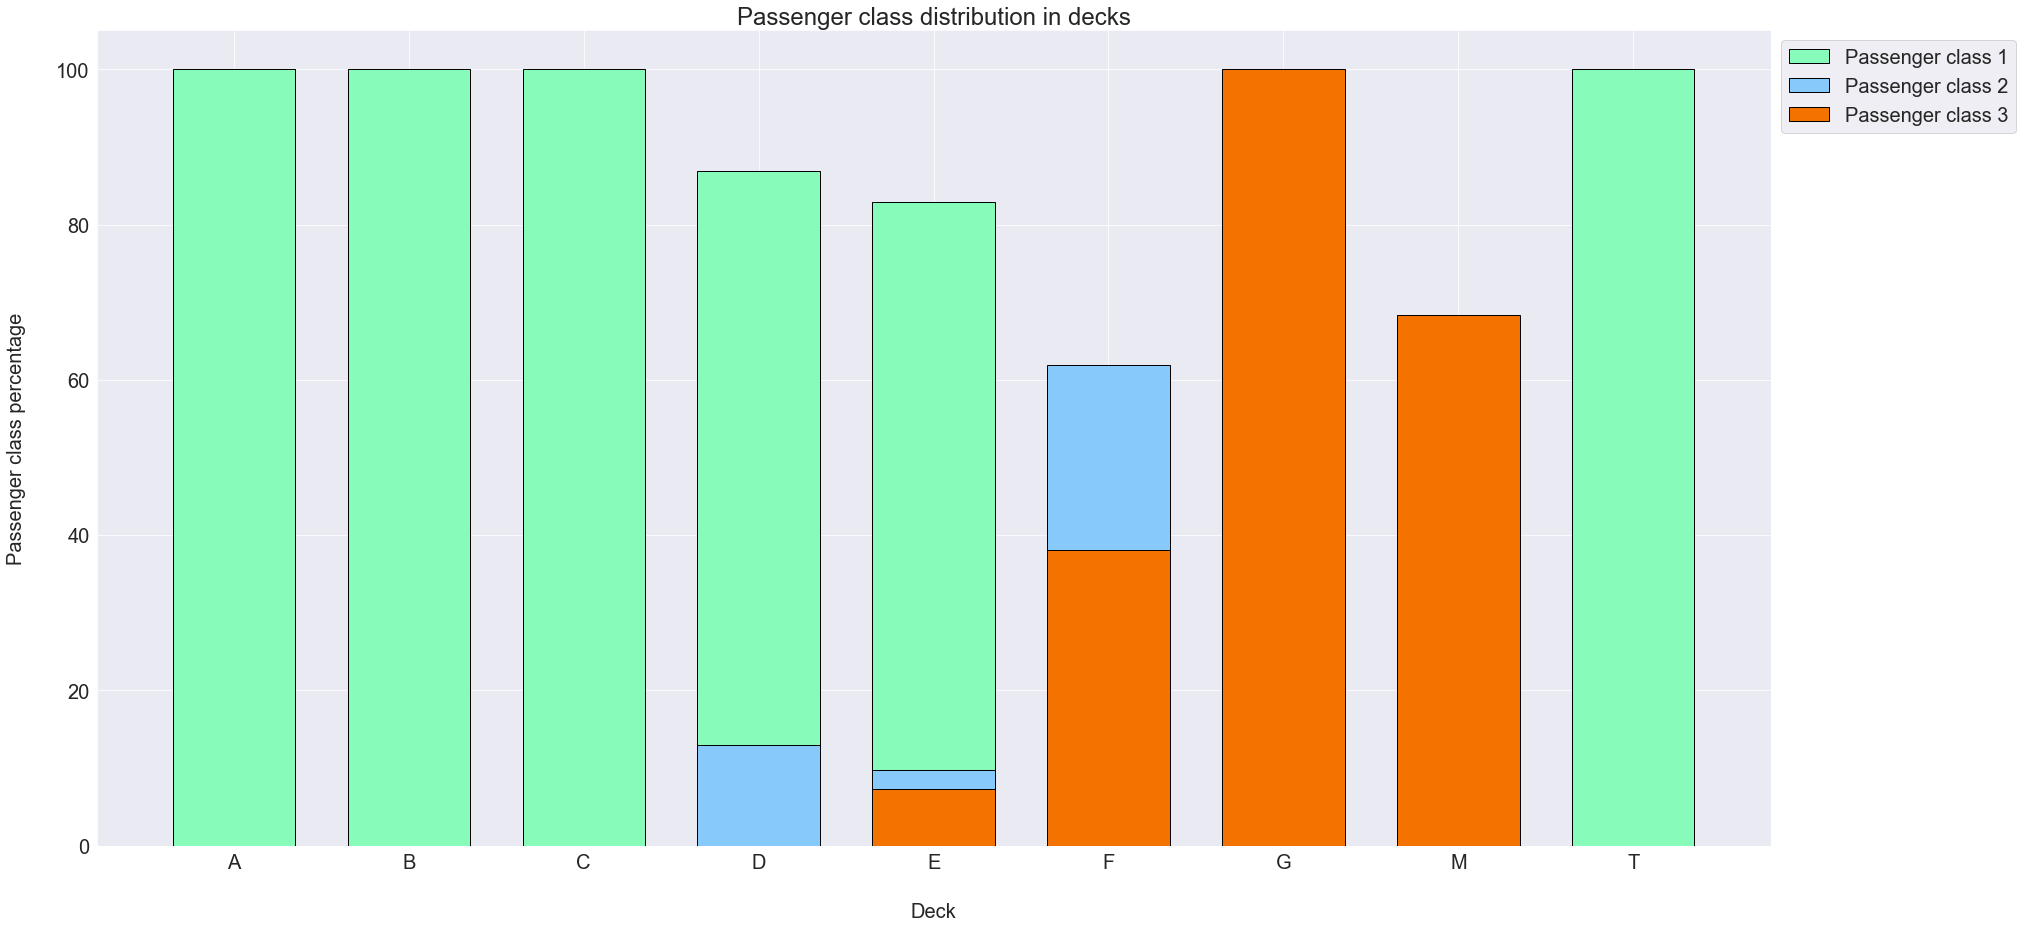

In [15]:
all_deck_count, all_deck_perc = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_perc)


In [16]:
all_deck_perc

{'A': [100.0, 0.0, 0.0],
 'B': [100.0, 0.0, 0.0],
 'C': [100.0, 0.0, 0.0],
 'D': [86.95652173913044, 13.043478260869565, 0.0],
 'E': [82.92682926829268, 9.75609756097561, 7.317073170731707],
 'F': [0.0, 61.904761904761905, 38.095238095238095],
 'G': [0.0, 0.0, 100.0],
 'M': [6.607495069033531, 25.04930966469428, 68.34319526627219],
 'T': [100.0, 0.0, 0.0]}

In [17]:
# Deck T has the closest resemblance to deck A, so that passenger will be regrouped with deck A
dect_regroup = df_all[df_all['Deck'] == 'T'].index
df_all.loc[dect_regroup, 'Deck'] = 'A'


In [18]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(
    columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']
).rename(columns={'Name': 'Count'}).transpose()

df_all_decks_survived


Deck       A       B       C       D       E       F       G        M     
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
Count      9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206

In [19]:
def get_survived_dist(df):
    surv_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M':{}, 'T': {}}

    decks = df.columns.levels[0]
    for deck in decks:
        for survive in range(0, 2):
                surv_counts[deck][survive] = df[deck][survive][0]

    df_surv = pd.DataFrame(surv_counts)

    # Created a dictionary for every passenger class count in every deck
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

    return surv_counts, surv_percentages

def display_survived_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.7

    not_survived = df_percentages[0]
    survived = df_percentages[1]

    plt.figure(figsize=(30, 15))
    plt.bar(bar_count, not_survived, color='#aa99aa', edgecolor='black', width=bar_width, label='Not survived')
    plt.bar(bar_count, survived, color='#33cc33', edgecolor='black', width=bar_width, label='Survived')

    plt.xlabel('Deck', size=20, labelpad=30)
    plt.ylabel('Survival percentage', size=20, labelpad=30)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 20})
    plt.title('Survival percentage in decks', size=24, y=1)

    plt.show()

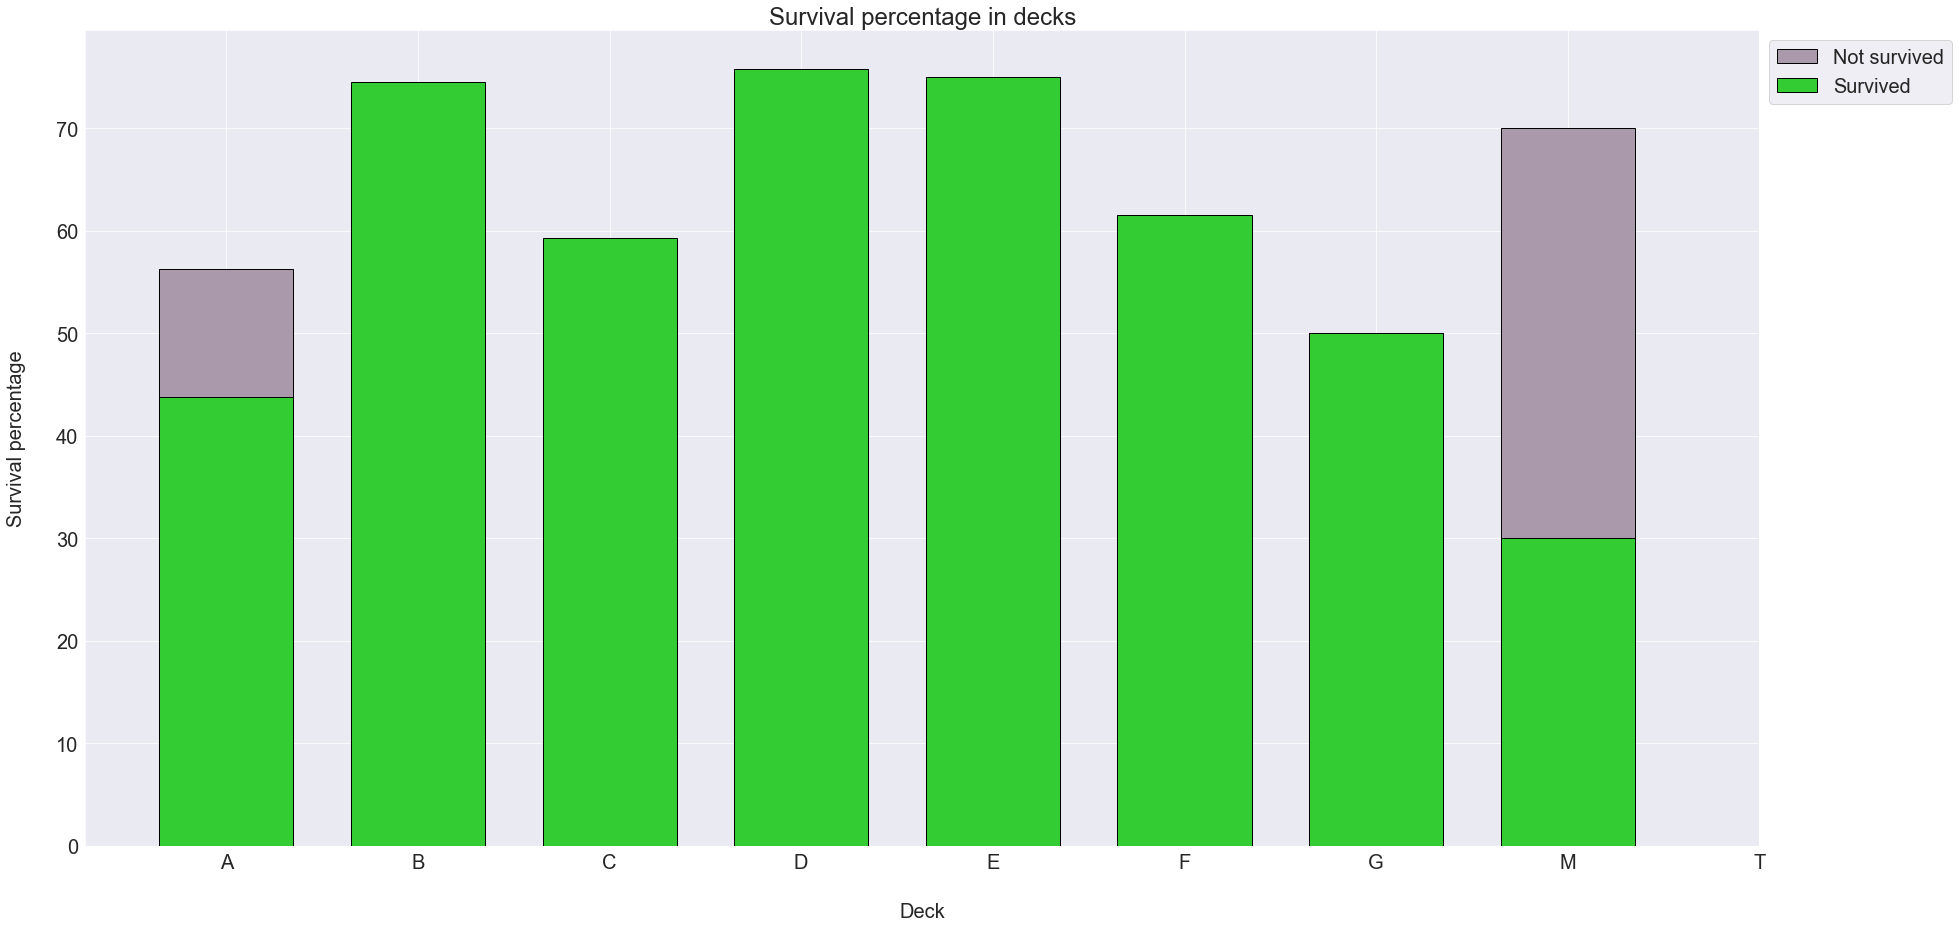

In [20]:
all_surv_counts, all_surv_perc = get_survived_dist(df_all_decks_survived)
display_survived_dist(all_surv_perc)


In [21]:
all_surv_perc


{'A': [56.25, 43.75],
 'B': [25.53191489361702, 74.46808510638297],
 'C': [40.67796610169492, 59.32203389830508],
 'D': [24.242424242424242, 75.75757575757575],
 'E': [25.0, 75.0],
 'F': [38.46153846153847, 61.53846153846154],
 'G': [50.0, 50.0],
 'M': [70.01455604075691, 29.985443959243085],
 'T': [nan, nan]}

In [22]:
# Regroup decks A, B, C as ABC, since all of them have only 1st class passengers
# Regroup decks D, E as DE, since both of them have similar passenger distribution and same survival rate
# Regroup decks F, G as FG, since both of them have similar passenger distribution and same survival rate
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()


M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [23]:
df_all.drop(['Cabin'], inplace=True, axis=1)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0
Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


#### Visualization

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers did not survive and it is the 61.62% of the training set.


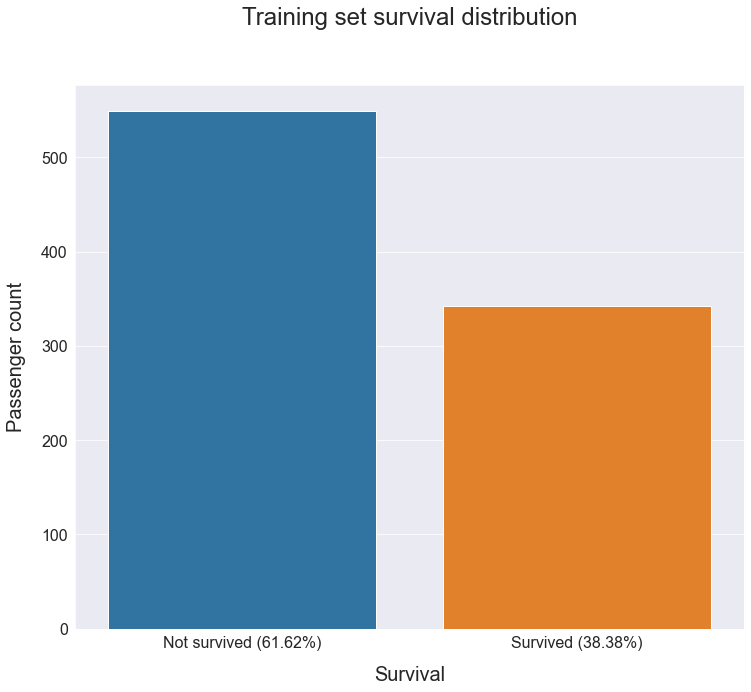

In [24]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers did not survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(12, 10))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=20, labelpad=15)
plt.ylabel('Passenger count', size=20, labelpad=15)
plt.xticks((0, 1), ['Not survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.title('Training set survival distribution', size=24, y=1.10)
plt.show()


In [25]:
# Training data
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_train_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation coefficient'] == 1.0].index)

# Test data
df_test_corr = df_test.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_test_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation coefficient'] == 1.0].index)


In [26]:
corr = df_train_corr_nd['Correlation coefficient'] > 0.1
df_train_corr_nd[corr]


,Feature 1,Feature 2,Correlation coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [27]:
corr = df_test_corr_nd['Correlation coefficient'] > 0.1
df_test_corr_nd[corr]


,Feature 1,Feature 2,Correlation coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


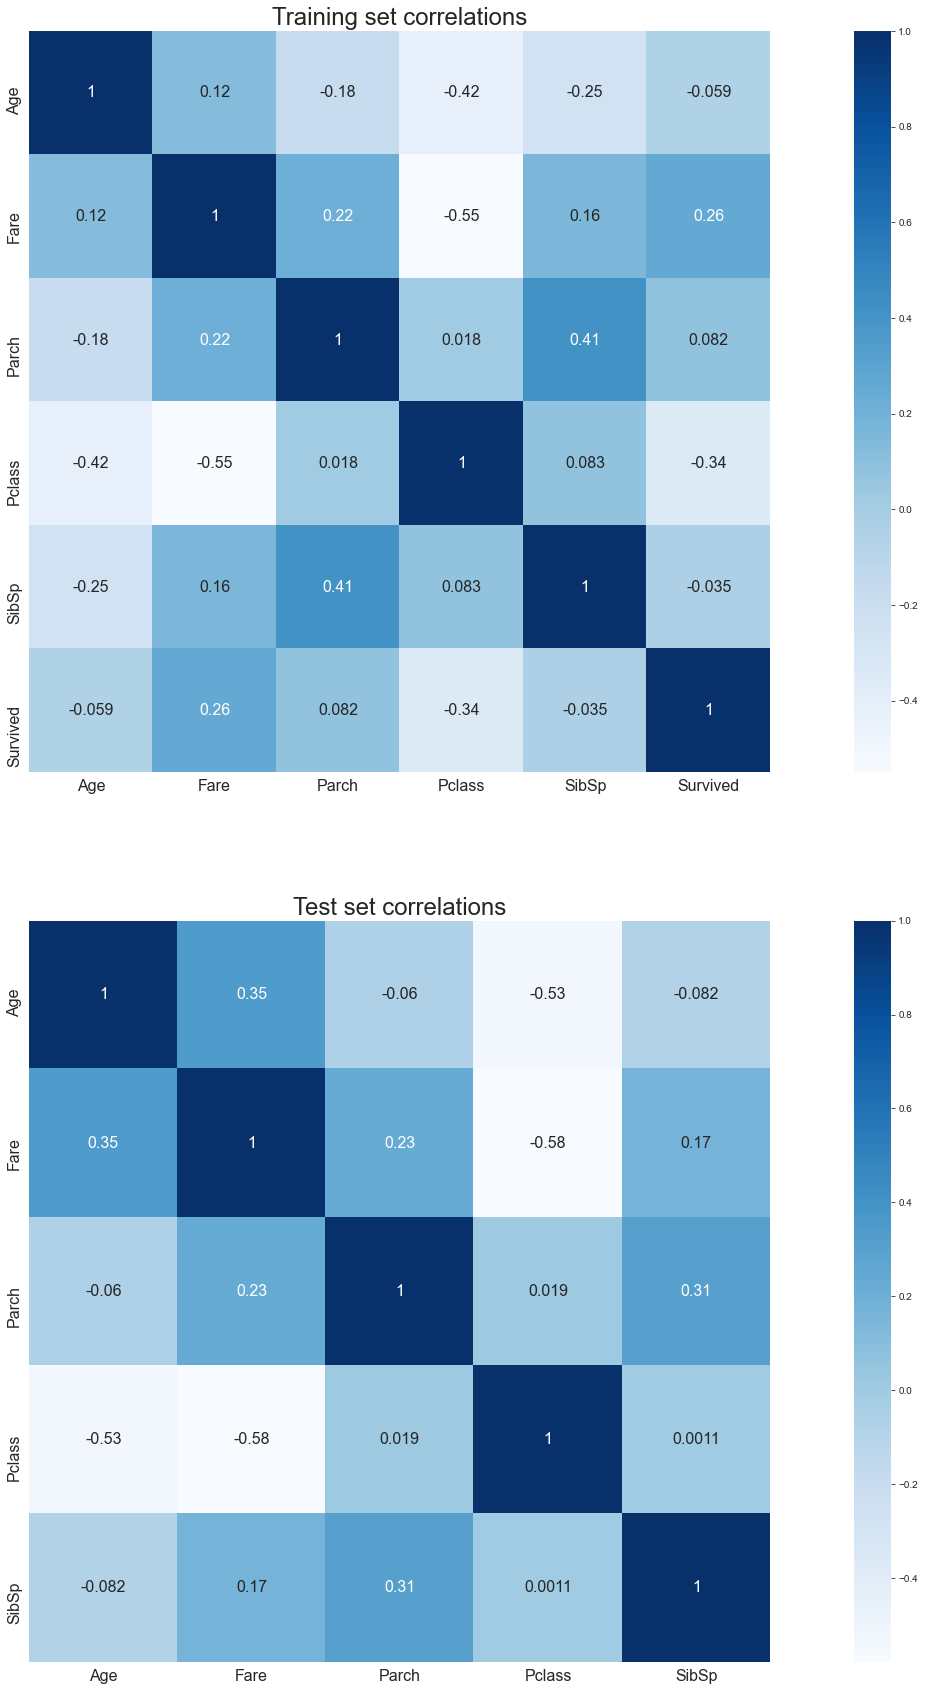

In [28]:
fig, axs = plt.subplots(nrows=2, figsize=(30, 30))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='Blues', annot_kws={'size': 16})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='Blues', annot_kws={'size': 16})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

axs[0].set_title('Training set correlations', size=24)
axs[1].set_title('Test set correlations', size=24)

plt.show()

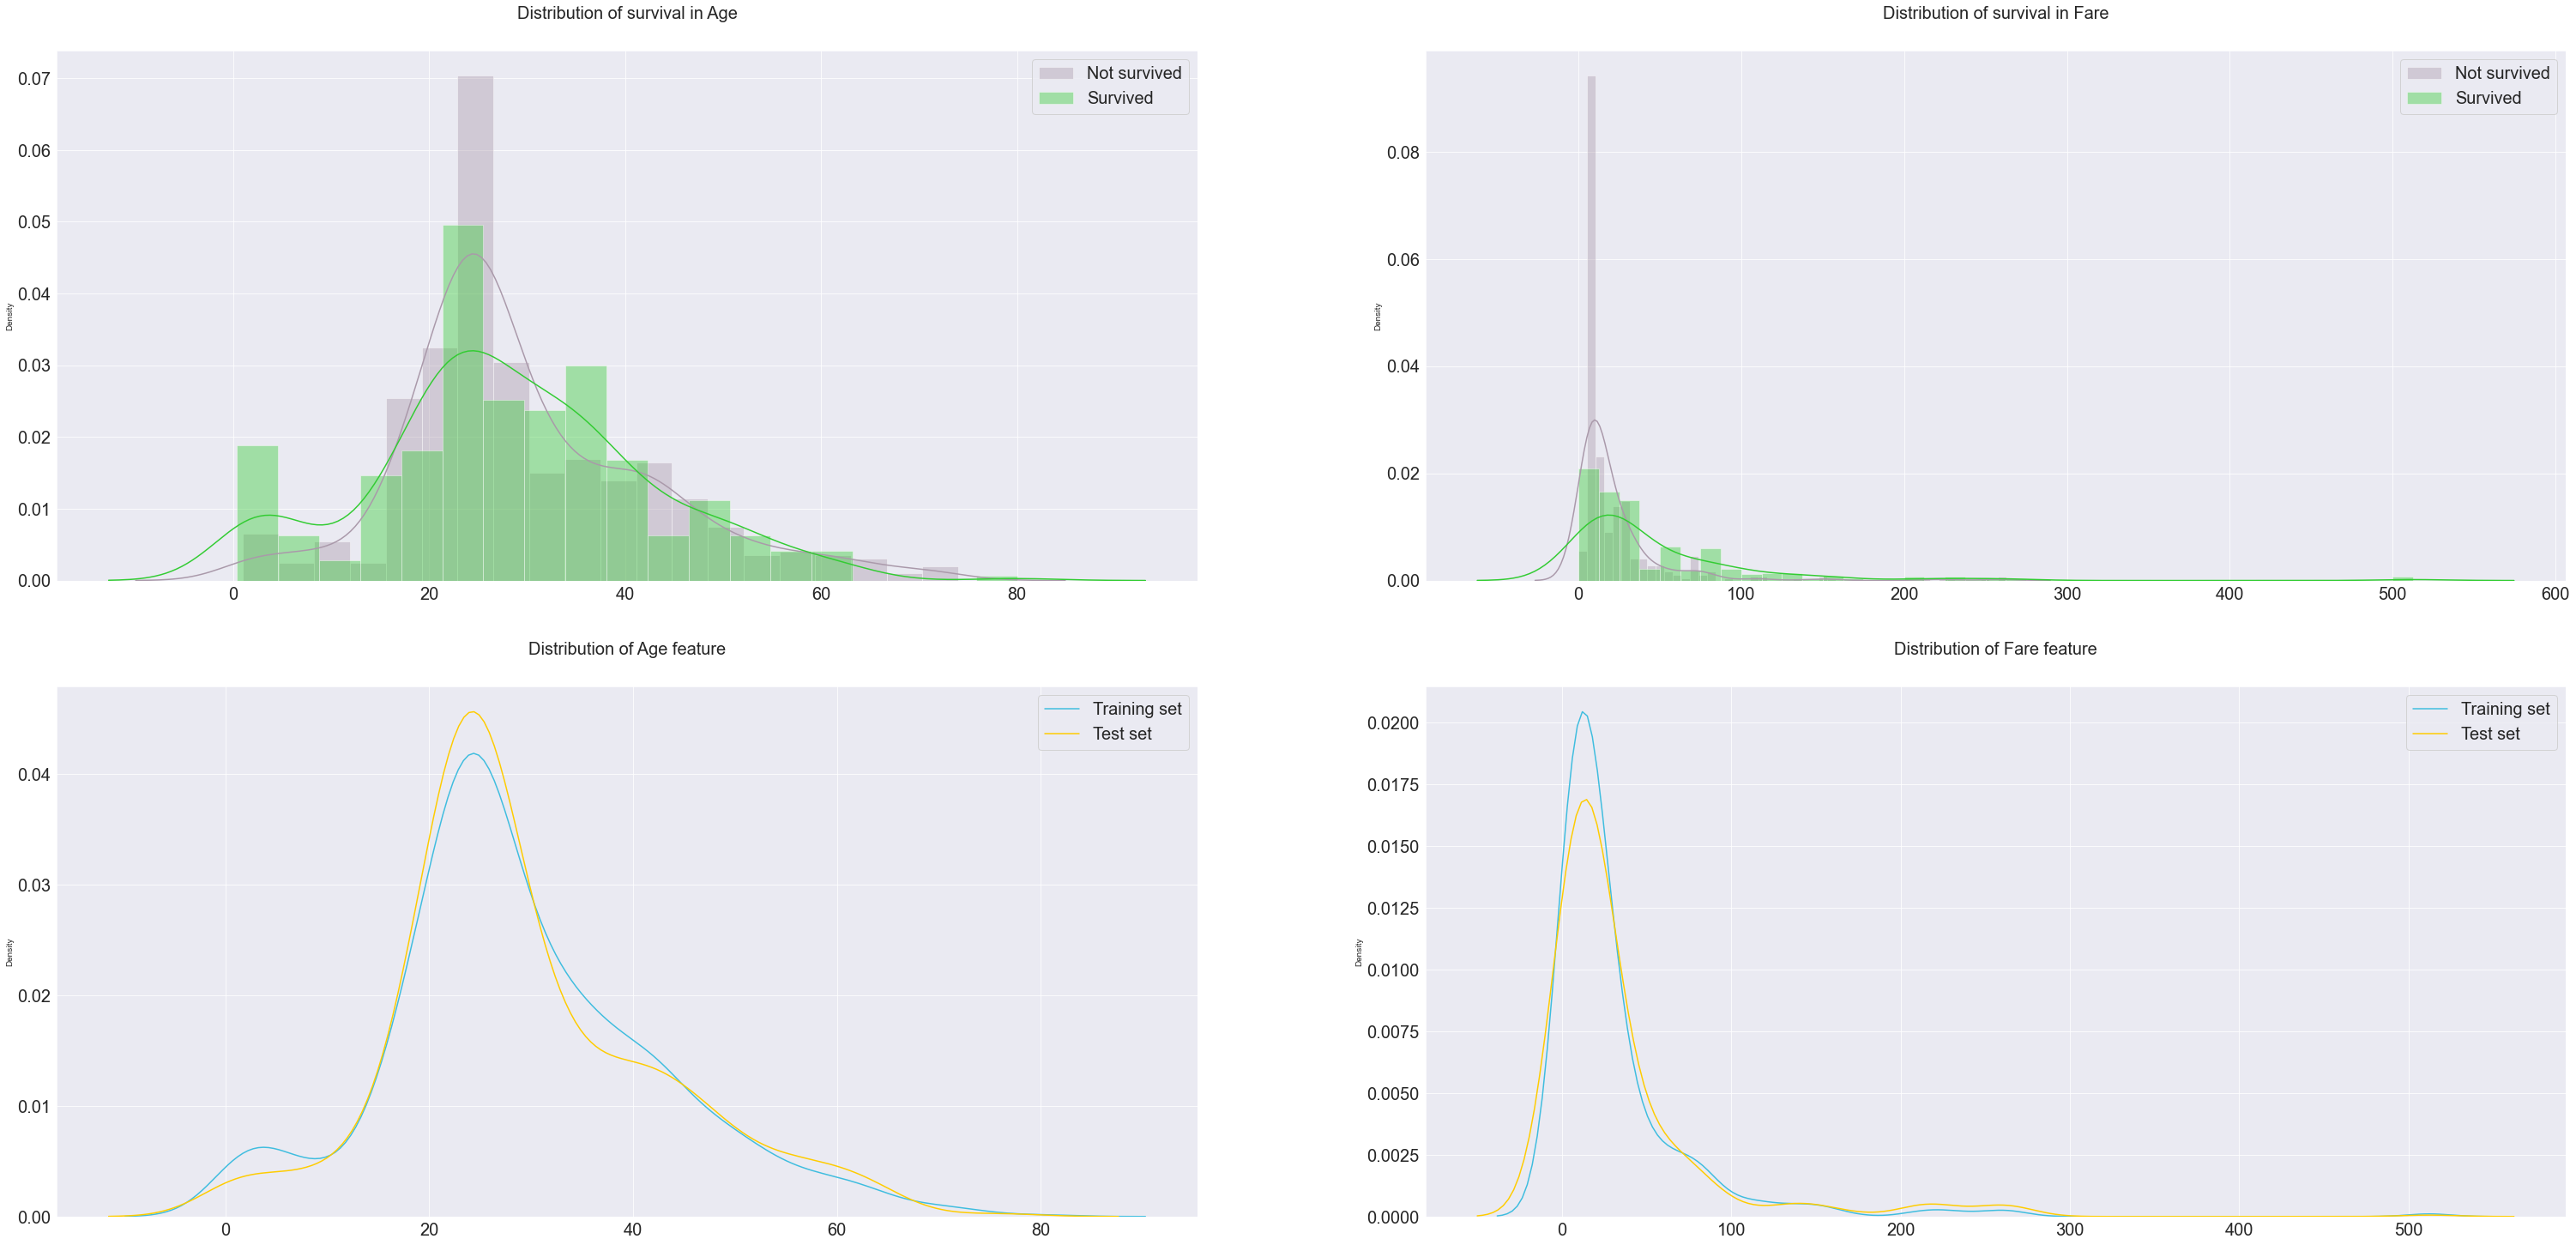

In [29]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(25, 25))
plt.subplots_adjust(right=1.75)

for i, feature in enumerate(cont_features):
    # Distribution of survival in age and fare features
    sns.distplot(df_train[~surv][feature], label='Not survived', hist=True, color='#aa99aa', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#33cc33', ax=axs[0][i])

    # Distribution of age and fare features in the training and test sets
    sns.distplot(df_train[feature], label='Training set', hist=False, color='#3fbddf', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test set', hist=False, color='#ffcc00', ax=axs[1][i])

    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')

    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)

    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} feature'.format('Fare'), size=20, y=1.05)

plt.show()

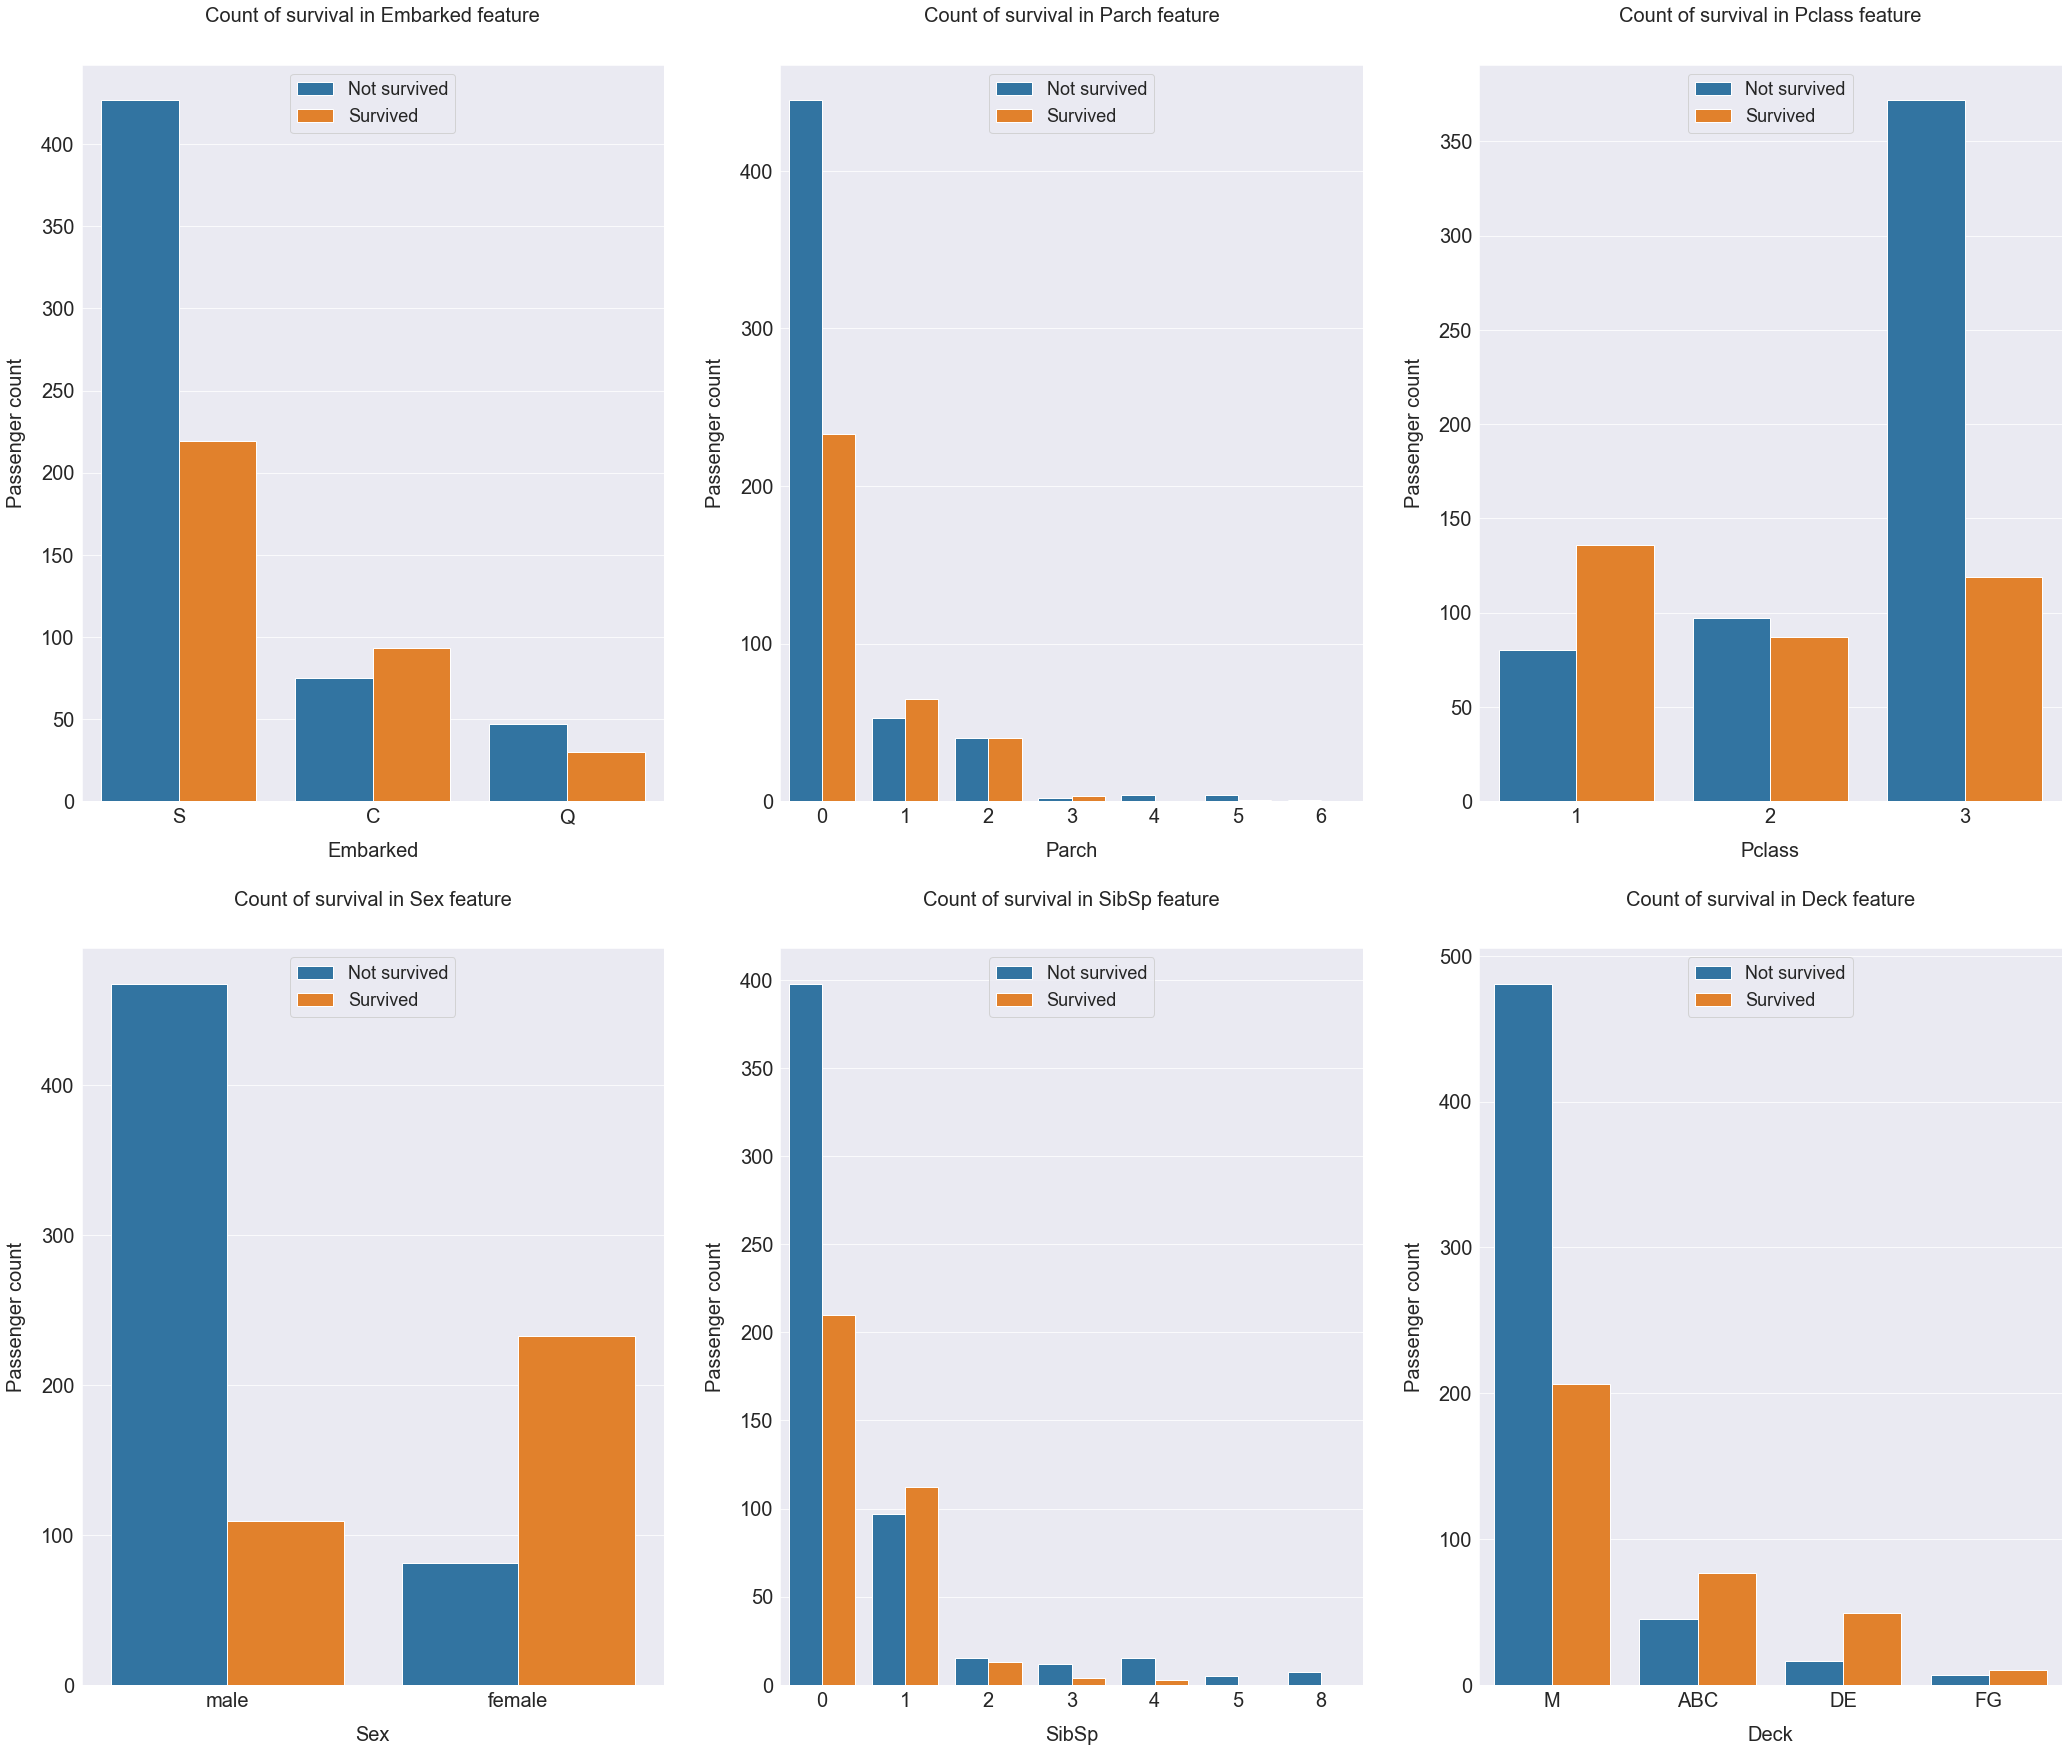

In [30]:
categorical_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)

    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger count', size=20, labelpad=15)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(['Not survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of survival in {} feature'.format(feature), size=20, y=1.05)

plt.show()

In [31]:
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
df_all.head()


,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


#### Feature engineering

In [32]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)


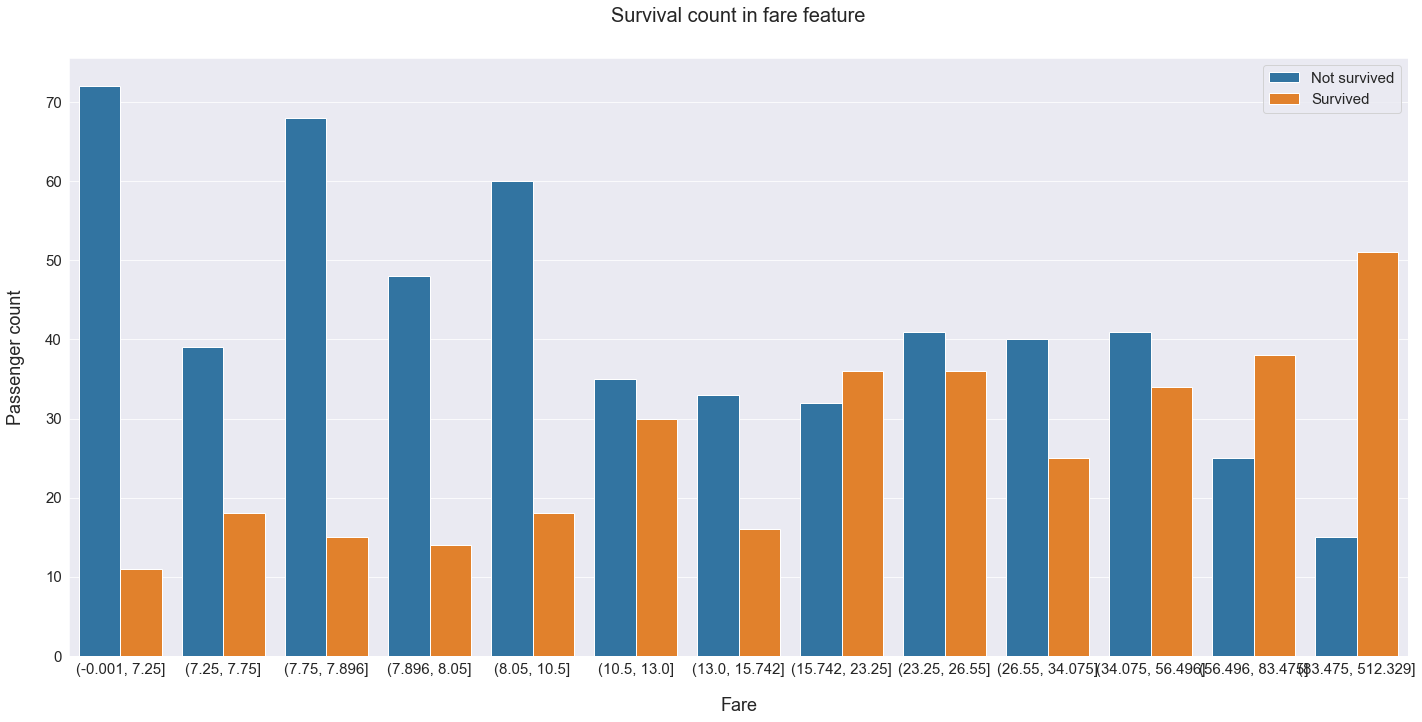

In [33]:
fig, axs = plt.subplots(figsize=(24, 11))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=18, labelpad=20)
plt.ylabel('Passenger count', size=18, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival count in {} feature'.format('fare'), size=20, y=1.05)

plt.show()


In [34]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)


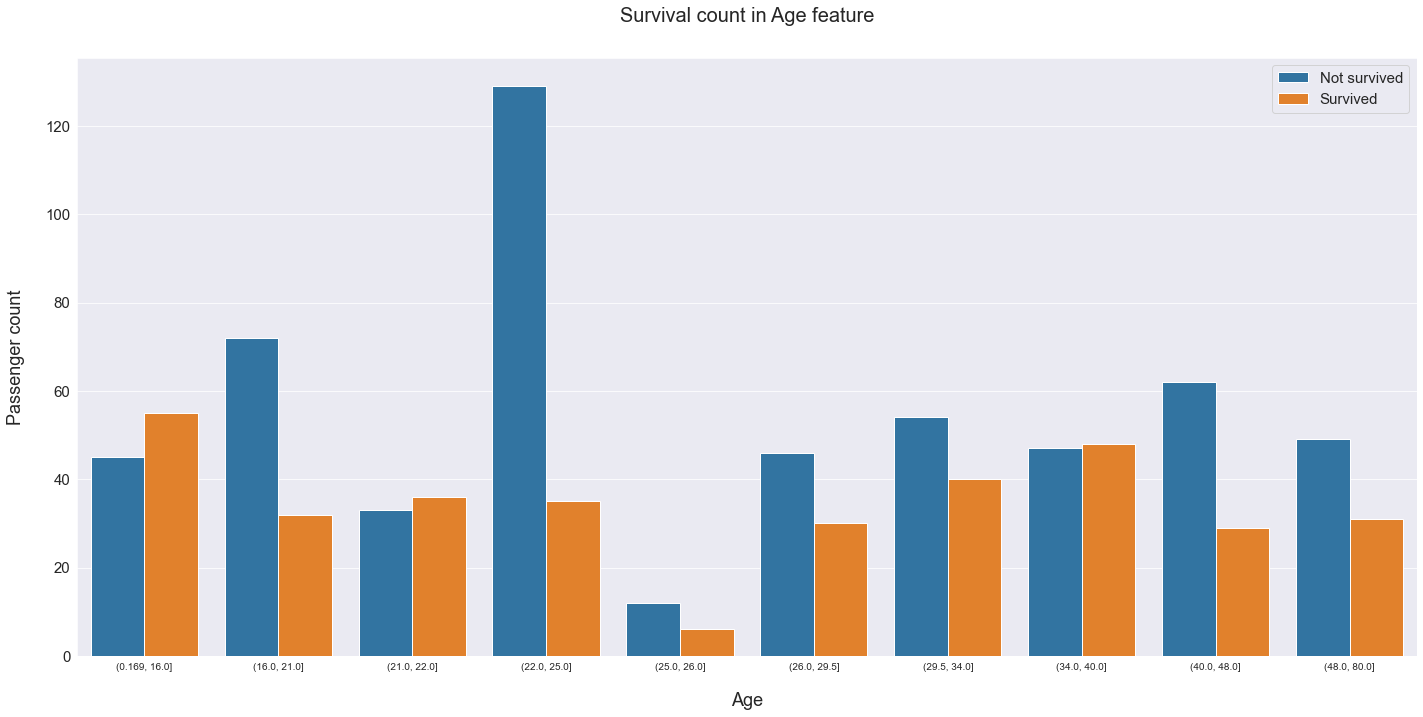

In [35]:
fig, axs = plt.subplots(figsize=(24, 11))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=18, labelpad=20)
plt.ylabel('Passenger count', size=18, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival count in {} feature'.format('Age'), size=20, y=1.05)

plt.show()

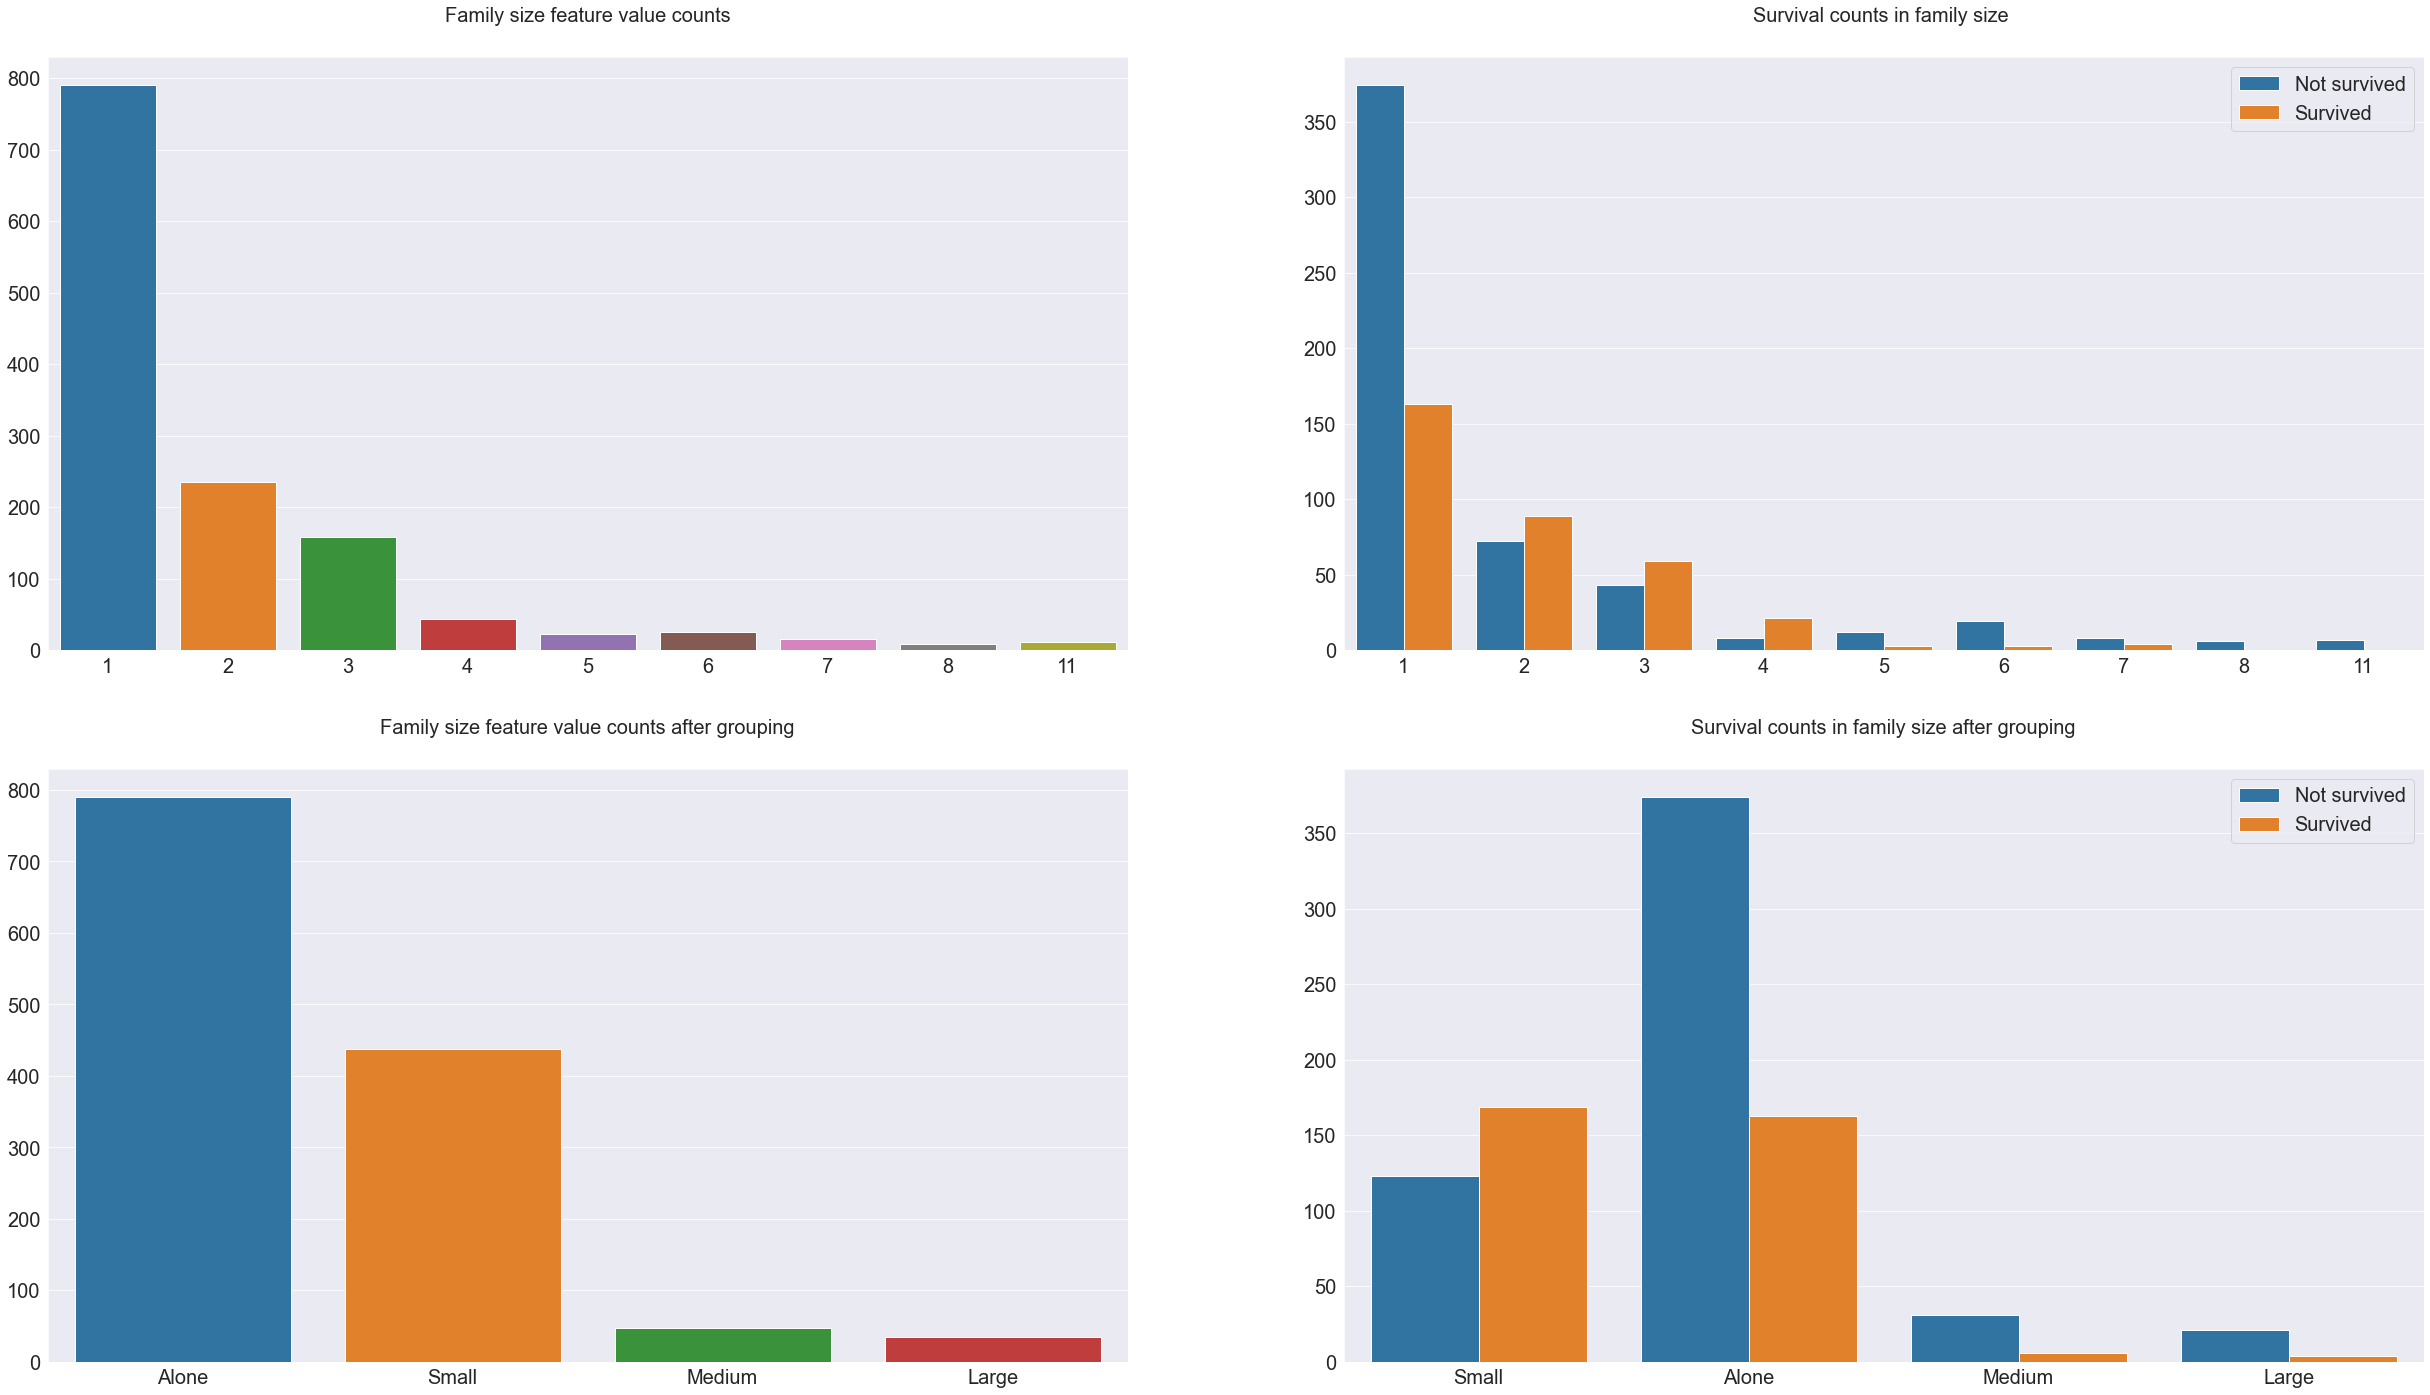

In [36]:
df_all['FamilySize'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(24, 24), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['FamilySize'].value_counts().index, y=df_all['FamilySize'].value_counts().values, ax=axs[0][0])
axs[0][0].set_title('Family size feature value counts', size=20, y=1.05)
sns.countplot(x='FamilySize', hue='Survived', data=df_all, ax=axs[0][1])
axs[0][1].set_title('Survival counts in family size ', size=20, y=1.05)

# Family Size with 1 are labeled as 'Alone'
# Family Size with 2, 3 and 4 are labeled as 'Small'
# Family Size with 5 and 6 are labeled as 'Medium'
# Family Size with 7, 8 and 11 are labeled as 'Large'
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

df_all['FamilySizeGrouped'] = df_all['FamilySize'].map(family_map)

sns.barplot(x=df_all['FamilySizeGrouped'].value_counts().index, y=df_all['FamilySizeGrouped'].value_counts().values, ax=axs[1][0])
axs[1][0].set_title('Family size feature value counts after grouping', size=20, y=1.05)
sns.countplot(x='FamilySizeGrouped', hue='Survived', data=df_all, ax=axs[1][1])
axs[1][1].set_title('Survival counts in family size after grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()


In [37]:
df_all['TicketFrequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')


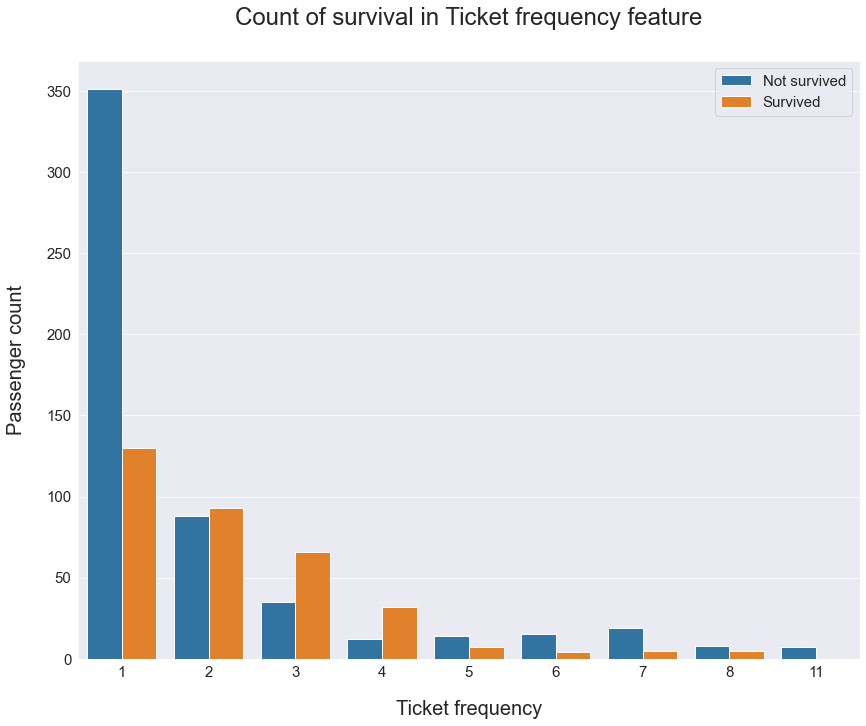

In [38]:
fig, axs = plt.subplots(figsize=(14, 11))
sns.countplot(x='TicketFrequency', hue='Survived', data=df_all)

plt.xlabel('Ticket frequency', size=20, labelpad=20)
plt.ylabel('Passenger count', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of survival in {} feature'.format('Ticket frequency'), size=24, y=1.05)

plt.show()


In [39]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1


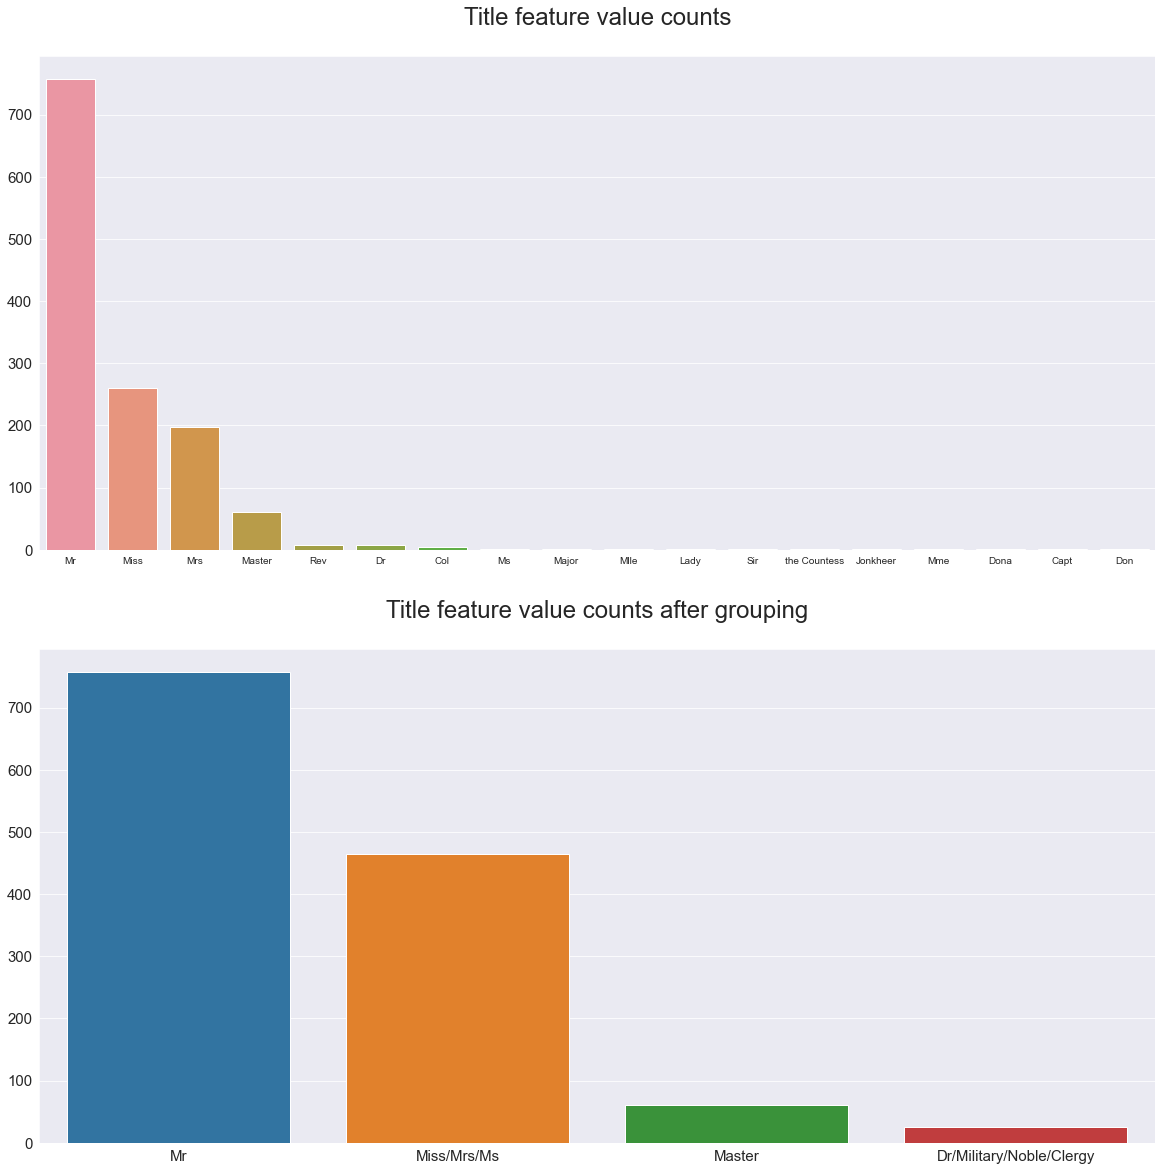

In [40]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])
axs[0].set_title('Title feature value counts', size=24, y=1.05)
axs[0].tick_params(axis='x', labelsize=10)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title feature value counts after grouping', size=24, y=1.05)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
    axs[i].tick_params(axis='y', labelsize=15)

plt.show()


In [41]:
def extract_surname(data):

    families = []

    for i in range(len(data)):
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name

        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]

        for c in string.punctuation:
            family = family.replace(c, '').strip()

        families.append(family)

    return families

# Family feature based on surnames
df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]


In [42]:
# List of families and tickets that are occurring in both training and test set
# List of family names (non_unique_families), that are occurring in both training and test set is created.
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','FamilySize'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','TicketFrequency'].median()

family_rates = {}
ticket_rates = {}

# Checked if a family exists in both training and test set, and has members more than 1
for i in range(len(df_family_survival_rate)):
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

# Checked if a ticket exists in both training and test set, and has members more than 1
for i in range(len(df_ticket_survival_rate)):
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]


In [43]:
# Family_Survival_Rate is calculated from families in training set since there is no Survived feature in test set.
# The survival rate is calculated for families with more than 1 members in that list, and stored in Family_Survival_Rate feature.
# An extra binary feature Family_Survival_Rate_NA is created for families that are unique to the test set.
# This extra feature is also necessary because there is no way to calculate those families' survival rate and implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)

df_train['FamilySurvivalRate'] = train_family_survival_rate
df_train['FamilySurvivalRateNA'] = train_family_survival_rate_NA
df_test['FamilySurvivalRate'] = test_family_survival_rate
df_test['FamilySurvivalRateNA'] = test_family_survival_rate_NA


In [44]:
# Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are also created with the same method.
train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)

df_train['TicketSurvivalRate'] = train_ticket_survival_rate
df_train['TicketSurvivalRateNA'] = train_ticket_survival_rate_NA
df_test['TicketSurvivalRate'] = test_ticket_survival_rate
df_test['TicketSurvivalRateNA'] = test_ticket_survival_rate_NA


In [45]:
# TicketSurvivalRate and FamilySurvivalRate are averaged and become Survival_Rate.
# TicketSurvivalRateNA and FamilySurvivalRateNA are also averaged and become Survival_Rate_NA.
for df in [df_train, df_test]:
    df['SurvivalRate'] = (df['TicketSurvivalRate'] + df['FamilySurvivalRate']) / 2
    df['SurvivalRateNA'] = (df['TicketSurvivalRateNA'] + df['FamilySurvivalRateNA']) / 2

In [46]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'FamilySizeGrouped', 'Age', 'Fare']

# LabelEncoder basically labels the classes from 0 to n, converting the aforementioned types into numerical type.
for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])


In [47]:
# The categorical features (Pclass, Sex, Deck, Embarked, Title) are converted to one-hot encoded features with OneHotEncoder.
categorical_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'FamilySizeGrouped']
encoded_features = []

for df in dfs:
    for feature in categorical_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)


In [48]:
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
drop_cols = ['Deck', 'Embarked', 'Family', 'FamilySize', 'FamilySizeGrouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'TicketSurvivalRate', 'FamilySurvivalRate', 'TicketSurvivalRateNA', 'FamilySurvivalRateNA']

df_all.drop(columns=drop_cols, inplace=True)
df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,FamilySizeGrouped_1,FamilySizeGrouped_2,...,Pclass_3,Sex_1,Sex_2,SurvivalRate,SurvivalRateNA,TicketFrequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


#### Model

In [49]:
df_all.columns

Index(['Age', 'Deck_1', 'Deck_2', 'Deck_3', 'Deck_4', 'Embarked_1',
       'Embarked_2', 'Embarked_3', 'FamilySizeGrouped_1',
       'FamilySizeGrouped_2', 'FamilySizeGrouped_3', 'FamilySizeGrouped_4',
       'Fare', 'Is_Married', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_1',
       'Sex_2', 'SurvivalRate', 'SurvivalRateNA', 'TicketFrequency', 'Title_1',
       'Title_2', 'Title_3', 'Title_4'],
      dtype='object')

In [50]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))


In [51]:
model = RandomForestClassifier(
    criterion='gini',
    n_estimators=1100,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=5,
    max_features='auto',
    oob_score=True,
    random_state=101,
    n_jobs=1,
    verbose=1
)


In [52]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=101, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))

    model.fit(X_train[trn_idx], y_train[trn_idx])

    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)

    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = model.feature_importances_

    oob += model.oob_score_ / N
    print('Fold {} OOB score: {}\n'.format(fold, model.oob_score_))

print('Average OOB score: {}'.format(oob))


Fold 1



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished


Fold 1 OOB score: 0.848314606741573

Fold 2



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished


Fold 2 OOB score: 0.8373071528751753

Fold 3



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished


Fold 3 OOB score: 0.8330995792426368

Fold 4



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished


Fold 4 OOB score: 0.8513323983169705

Fold 5



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fold 5 OOB score: 0.8583450210378681

Average OOB score: 0.8456797516428449


[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed:    0.1s finished


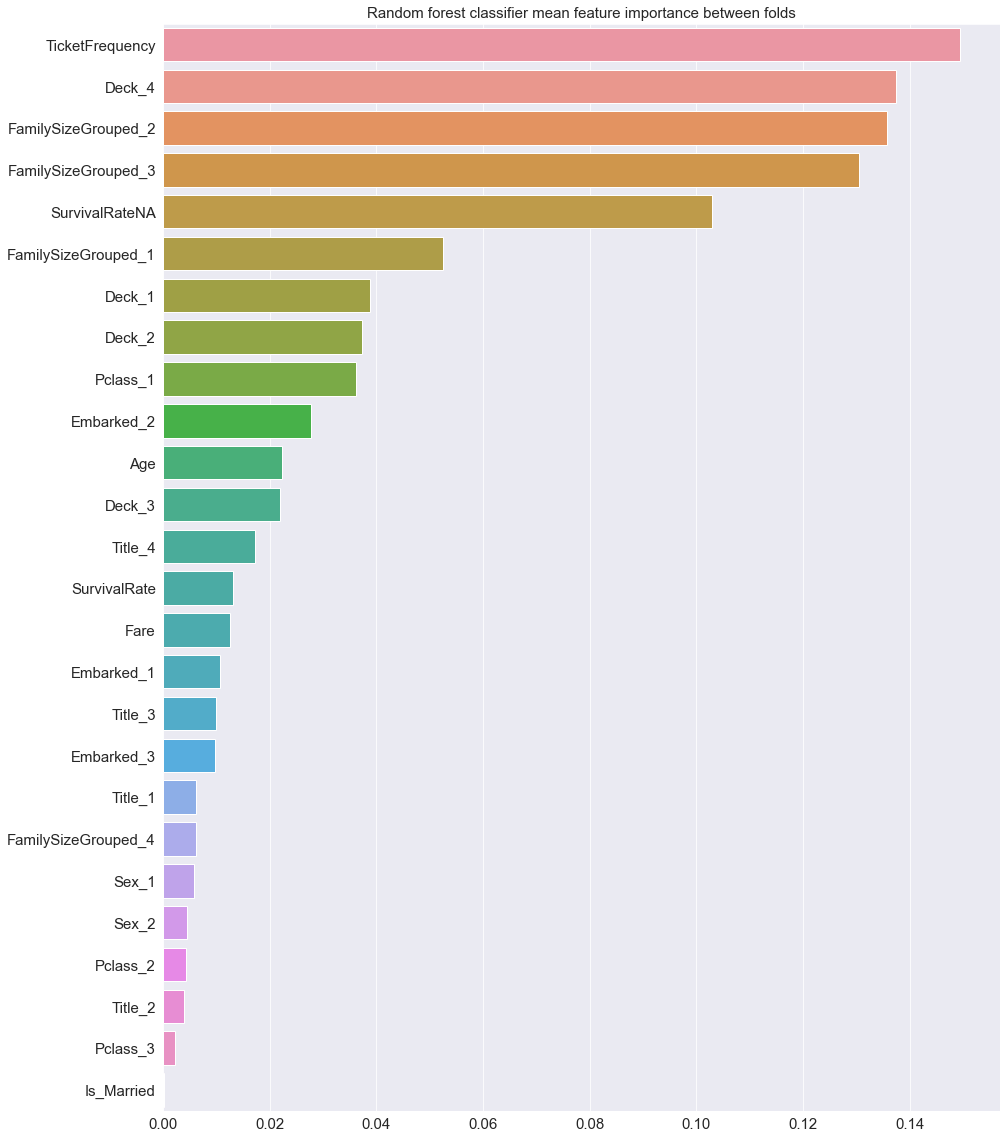

In [53]:
importances['MeanImportance'] = importances.mean(axis=1)
importances.sort_values(by='MeanImportance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='MeanImportance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random forest classifier mean feature importance between folds', size=15)

plt.show()


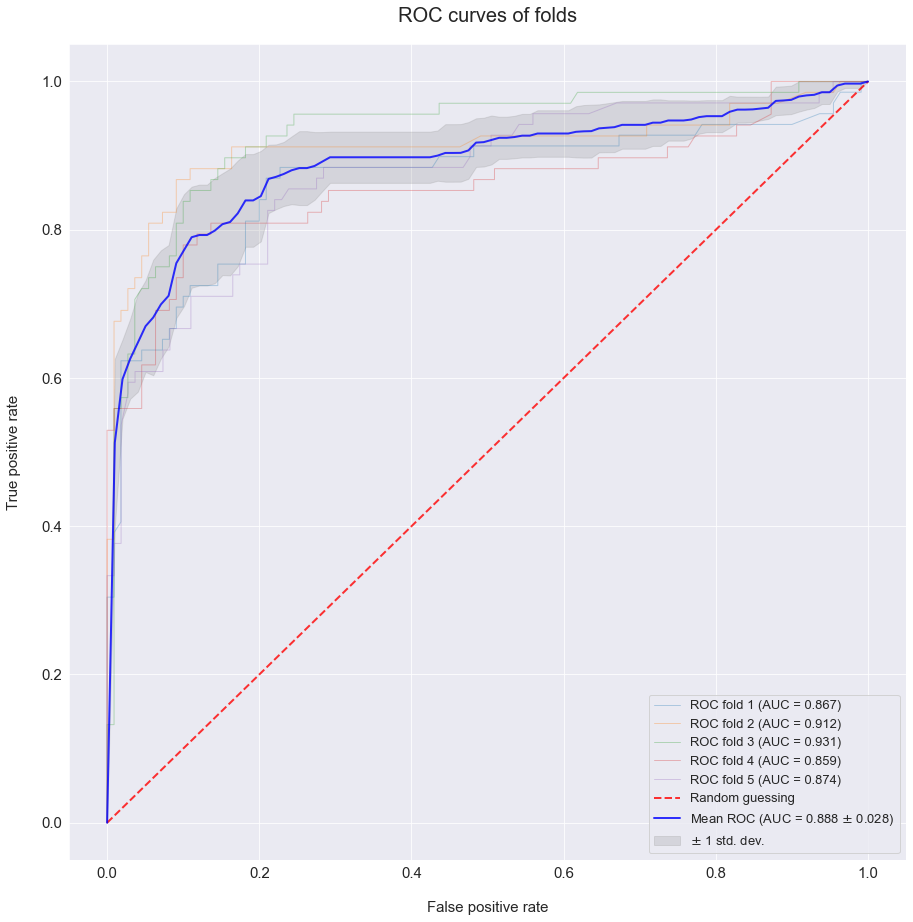

In [54]:
def plot_roc_curve(fprs, tprs):

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))

    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold {} (AUC = {:.3f})'.format(i, roc_auc))

    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random guessing')

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)

    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')

    ax.set_xlabel('False positive rate', size=15, labelpad=20)
    ax.set_ylabel('True positive rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC curves of folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})

    plt.show()

plot_roc_curve(fprs, tprs)


In [55]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('output/submission1.csv', header=True, index=False)
